# Importing Data

In [16]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime as dt
import yfinance as yf

In [17]:
us_data_path = '/Users/talhajamal/Documents/Documents/Imperial/Courses/Semester 2/Empirical Finance/IndividualProject/coursework_1/Data_coursework_1.xlsx'
us_data = pd.read_excel(us_data_path, sheet_name='US')
us_data['Date'] = pd.to_datetime(us_data['Date'], dayfirst=True)
#start_date = dt(1984, 1, 1)
#us_data = us_data[us_data['Date'] > start_date] # Last 40 years of data

In [18]:
# Summary Statistics for US Data
us_data["Simple Returns"] = us_data['Stock Index'].pct_change()
us_data["Log Returns"] = np.log(us_data['Stock Index'] / us_data['Stock Index'].shift(1))
us_data["ST Returns"] = us_data['Short-term Yield'].pct_change()
us_data["LT Returns"] = us_data['Long-term Yield'].pct_change()
us_data['xt_1'] = us_data['Long-term Yield'].shift(1) - us_data['Short-term Yield'].shift(1)
us_data.dropna(inplace=True)
us_data.reset_index(drop = True, inplace=True)
us_data.head()

,Date,Stock Index,Short-term Yield,Long-term Yield,Simple Returns,Log Returns,ST Returns,LT Returns,xt_1
0,1792-02-29,2.496140,4.198,4.198,0.062644,0.060760,0.061173,0.061173,0.0
1,1792-03-31,2.297596,4.940,4.940,-0.079541,-0.082882,0.176751,0.176751,0.0
2,1792-04-30,2.350072,5.143,5.143,0.022840,0.022583,0.041093,0.041093,0.0
3,1792-05-31,2.562141,4.557,4.557,0.090239,0.086397,-0.113941,-0.113941,0.0
4,1792-06-30,2.512370,4.675,4.675,-0.019426,-0.019617,0.025894,0.025894,0.0


# Expanding Window Regression

In [30]:
# Expanding Window Regression
expanding_model_prediction = []
expanding_benchmark_prediction = []
expanding_actual = []

for i in range(120, len(us_data) - 1, 1): #2784
    #setup data
    x_train = us_data[['xt_1']][:i]
    y_train = us_data[['Log Returns']][:i]
    # Run Regression
    expanding_model = LinearRegression()
    expanding_model.fit(x_train, y_train)
    # Test and Prediction
    x_test = us_data[['xt_1']][i:i+1]
    y_pred = expanding_model.predict(x_test)[0][0]
    actual = us_data['Log Returns'].iloc[i]
    benchmark_prediction = np.mean(y_train)
    # Appending to lists
    expanding_model_prediction.append(y_pred)
    expanding_actual.append(actual)
    expanding_benchmark_prediction.append(benchmark_prediction)

expanding_mse_model = mean_squared_error(expanding_actual, expanding_model_prediction)
expanding_mse_benchmark = mean_squared_error(expanding_actual, expanding_benchmark_prediction)

print(expanding_mse_model, expanding_mse_benchmark)
print("The out of sample R squared is: ", 1 - (mse_model/mse_benchmark))

delta_rmse = np.sqrt(expanding_mse_benchmark) - np.sqrt(expanding_mse_model)
print("The Delta RMSE is: ", delta_rmse)

0.001945448402323024 0.0019370741194388087
The out of sample R squared is:  -0.004323160791927627
The Delta RMSE is:  -9.503331749566996e-05


This Implies that the Model is NOT better than the Benchmark.

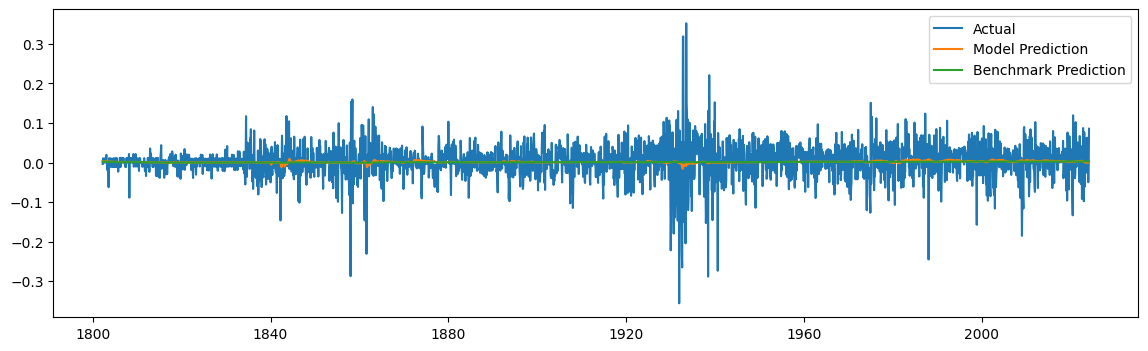

In [35]:
plt.figure(figsize=(14,4))
plt.plot(us_data['Date'][121:], expanding_actual, label='Actual')
plt.plot(us_data['Date'][121:], expanding_model_prediction, label = 'Model Prediction')
plt.plot(us_data['Date'][121:], expanding_benchmark_prediction, label = 'Benchmark Prediction')
plt.legend()

# Rolling Window Regression

In [29]:
# Expanding Window Regression
rolling_model_prediction = []
rolling_benchmark_prediction = []
rolling_actual = []

for i in range(120, len(us_data) - 1, 1): #2784
    #setup data
    start = i - 120
    x_train = us_data[['xt_1']][start:i]
    y_train = us_data[['Log Returns']][start:i]
    # Run Regression
    rolling_model = LinearRegression()
    rolling_model.fit(x_train, y_train)
    # Test and Prediction
    x_test = us_data[['xt_1']][i:i+1]
    y_pred = expanding_model.predict(x_test)[0][0]
    actual = us_data['Log Returns'].iloc[i]
    benchmark_prediction = np.mean(y_train)
    # Appending to lists
    rolling_model_prediction.append(y_pred)
    rolling_actual.append(actual)
    rolling_benchmark_prediction.append(benchmark_prediction)

rolling_mse_model = mean_squared_error(rolling_actual, rolling_model_prediction)
rolling_mse_benchmark = mean_squared_error(rolling_actual, rolling_benchmark_prediction)

print(rolling_mse_model, rolling_mse_benchmark)
print("The out of sample R squared is: ", 1 - (rolling_mse_model/rolling_mse_benchmark))

delta_rmse = np.sqrt(rolling_mse_benchmark) - np.sqrt(rolling_mse_model)
print("The Delta RMSE is: ", delta_rmse)

0.0019340843973446702 0.0019483483741248551
The out of sample R squared is:  0.007321060735142937
The Delta RMSE is:  0.0001618729889868789


This implies that the Rolling Window Regression Model outperforms the Benchmark Model. 

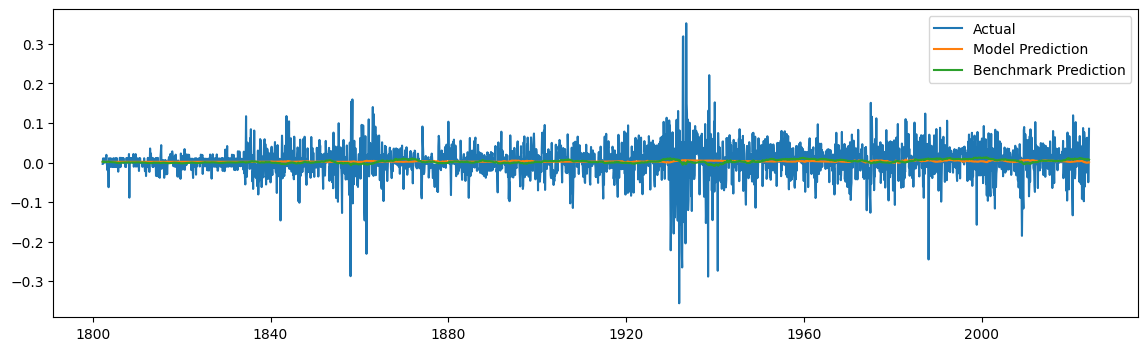

In [33]:
plt.figure(figsize=(14,4))
plt.plot(us_data['Date'][121:], rolling_actual, label='Actual')
plt.plot(us_data['Date'][121:], rolling_model_prediction, label = 'Model Prediction')
plt.plot(us_data['Date'][121:], rolling_benchmark_prediction, label = 'Benchmark Prediction')
plt.legend()

# Clark and West Test

In [59]:
# Clark and West Test
forecast_error = []
for i in range(len(expanding_model_prediction)):
    benchmark_error = np.square(expanding_actual[i] - expanding_benchmark_prediction[i])
    model_error = np.square(expanding_actual[i] - expanding_model_prediction[i])
    correction_term = np.square(expanding_benchmark_prediction[i] - expanding_model_prediction[i])
    forecast_error.append(benchmark_error - (model_error - correction_term))

cw_stat = np.mean(forecast_error) / (np.std(forecast_error) / np.sqrt(len(forecast_error)))
print("The CW Stat is: ", cw_stat)    
p_value = 2 * (1 - scipy.stats.t.cdf(abs(cw_stat), df=len(forecast_error) - 1))
print("The P Value is:", p_value)

The CW Stat is:  -0.7832054827729105
The P Value is: 0.4335761277949337


Cannot reject the Null Hypothesis that MSE benchmark = MSE model

In [61]:
# Clark and West Test
forecast_error = []
for i in range(len(rolling_model_prediction)):
    benchmark_error = np.square(rolling_actual[i] - rolling_benchmark_prediction[i])
    model_error = np.square(rolling_actual[i] - rolling_model_prediction[i])
    correction_term = np.square(rolling_benchmark_prediction[i] - rolling_model_prediction[i])
    forecast_error.append(benchmark_error - (model_error - correction_term))

cw_stat = np.mean(forecast_error) / (np.std(forecast_error) / np.sqrt(len(forecast_error)))
print("The CW Stat is: ", cw_stat)    
p_value = 2 * (1 - scipy.stats.t.cdf(abs(cw_stat), df=len(forecast_error) - 1))
print("The P Value is:", p_value)

The CW Stat is:  3.1118989674886577
The P Value is: 0.0018785995436241265


Reject the Null Hypothesis that MSE benchmark is = MSE model.

# Market Timing Ability

In [69]:
# Expanding Model
c = 0
for i in range(len(expanding_model_prediction)):
    if expanding_model_prediction[i] > 0 and expanding_actual[i] > 0:
        c += 1
    elif expanding_model_prediction[i] < 0 and expanding_actual[i] < 0:
        c += 1
n = len(expanding_model_prediction)
expanding_p = c / n
z_score = (expanding_p - 0.5) / np.std(expanding_p)
z_score

/var/folders/z8/18vf272n36z6tx1xm5tv3qvw0000gn/T/ipykernel_47576/1407388902.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (expanding_p - 0.5) / np.std(expanding_p)


inf

In [68]:
# Rolling Model
c = 0
for i in range(len(rolling_model_prediction)):
    if rolling_model_prediction[i] > 0 and rolling_actual[i] > 0:
        c += 1
    elif rolling_model_prediction[i] < 0 and rolling_actual[i] < 0:
        c += 1
n = len(rolling_model_prediction)
rolling_p = c / n
rolling_p

0.5208411565903117